# Импорт

In [1]:
import matplotlib.pyplot as plt # библиотека для построения графиков и диаграмм
import numpy as np              # библиотека для научных вычислений и работы с массивами чисел
import os                       # библиотека для работы с файлами и каталогами операционной системы
import pandas as pd             # библиотека для работы с табличными данными
import pydicom                  # библиотека для работы с DICOM-изображениями в медицине.
import tensorflow as tf         # библиотека для создания и обучения искусственных нейронных сетей

from PIL import Image           # библиотека для работы с изображениями
from sklearn.model_selection import train_test_split # Разбиение на тренировочную и тестовую выборки


# Анализ набора данных

https://mosmed.ai/en/datasets/aie21selftestmri/

```
PAN_BOT_anon             22
ING15_GB3_anon           24
INTERA_GKB12_anon        25
MRI84653_anon            29
EXCELMRI_GP22_anon      369
EXCELMRI_DC3_anon       481
EXCELMRI_GP8_anon       536
EXCELMRI_GVV2_anon      681
EXCELMRI_GKB71_anon     691
EXCELMRI_GKB57_anon     718
EXCELMRI_GP9_anon       818
HDX_MR_anon             828
EXCELMR_GB13_anon       830
EXCELMR_VERES_anon      832
EXCELMRI_GP134_anon     885
EXCELMRI_GKB36_anon     957
EXCELMRI_GP19_anon      967
EXCELMRI_GP209_anon    1086
EXCELMRI_GP212_anon    1154
EXCELMRI_GP214_anon    1204
EXCELMRI_GKB50_anon    1226
EXCELMRI_GP195_anon    1302
EXCELMRI_KDC4_anon     1306
EXCELMRI_GVV3_anon     1315
MR_GP46F1_anon         1339
EXCELMRI_GP52_anon     1359
EXCELMRI_GP67_anon     1392
EXCELMRI_GP68_anon     1574
EXCELMRI_MUH_anon      1633
EXCELMR1_GB1_anon      1644
EXCELMR_NPPCS_anon     1717
EXCELMRI_GP45_anon     1718
EXCELMRI_GP6_anon      1764
EXCELMRI_GP220_anon    1816
EXCELMR_YUD_anon       1833
EXCELMRI_GP2_anon      1947
EXCELMRI_KDC6_anon     2035
EXCELMRI_SM4_anon      2102
EXCELMR2_GB1_anon      2113
EXCELMRI_GVV1_anon     2312
ING30_MDGKB_anon       2410
EXCELMRI_GKB29_anon    2873
Name: major_dir, dtype: int64

labels.xlsx

        study_uid	                                        sclerosis
0	1.2.643.5.1.13.13.12.2.77.8252.011411090410101...	0
1	1.2.643.5.1.13.13.12.2.77.8252.131500041112120...	1
2	1.2.643.5.1.13.13.12.2.77.8252.010305060009140...	0
3	1.2.643.5.1.13.13.12.2.77.8252.071406031309010...	1
4	1.2.643.5.1.13.13.12.2.77.8252.121511041410151...	0
...	...	...
167	1.2.643.5.1.13.13.12.2.77.8252.111211060701140...	1
168	1.2.643.5.1.13.13.12.2.77.8252.100815141103051...	0
169	1.2.643.5.1.13.13.12.2.77.8252.060804010900090...	1
170	1.2.643.5.1.13.13.12.2.77.8252.030410101303070...	0
171	1.2.643.5.1.13.13.12.2.77.8252.040811010609121...	1
172 rows × 2 columns
```
В наборе данных есть фотографии разных размеров. Вот список их размеров shape в списке [(384, 416), (748, 640), (384, 384), (512, 512), (384, 384), (768, 768), (288, 288), (640, 640), (384, 384), (384, 384), (768, 768), (22, 192, 192), (384, 384), (768, 768), (640, 640), (512, 512), (768, 768), (384, 384), (576, 576), (384, 384), (384, 384), (768, 768), (768, 768), (384, 384), (768, 768), (576, 576), (23, 192, 192), (48, 128, 128), (512, 512), (25, 192, 192), (768, 768), (192, 192), (384, 384), (384, 384), (384, 384), (512, 512), (640, 640), (768, 768), (512, 512), (640, 640), (384, 384), (768, 768)]

Всего 43 папки. Внутри каждой 4 исследования. Внутри каждого исследования папки с dcm. Общий объем 51 Гб. Предаврительно оставили только поперечные разрезы (продольные не нужны).

Для начала, нужно определить какой dcm к какому классу относится. Напишем код на основе таблицы labels.xlsx, заменим название исследования на dcm. Далее распределим dcm по выборкам и сгенерим на их основе изображения одного размера. Сохраним изображения по соответсвующим каталогам.

Напишем функции для подготовки данных к машинному обучению.


In [2]:
# Функция для получения списка файлов
def get_files(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.dcm'):
                yield (os.path.join(root, file))

# Создаем папку если ее нет
def mkf(tofolder):
    if not os.path.exists(tofolder):
        os.mkdir(tofolder)
    return tofolder

# Конвертируем из dcm в jpg        
def safe_image(path, tofolder):
    # Конвертируем
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32) # преобразование изображения в numpy-массив
    intercept = dcm.RescaleIntercept if 'RescaleIntercept' in dcm else 0.0
    slope = dcm.RescaleSlope if 'RescaleSlope' in dcm else 1.0
    img = slope * img + intercept # масштабирование
    if len(img.shape) > 2:
        img = img[0]
    img -= img.min()
    img /= img.max()
    img *= 255.0
    img = img.astype('uint8')
    image = Image.fromarray(img)

    # Сохраняем словарь в файл
    # создаем папку для сохранения фрагментов словаря-датасета
    if not os.path.exists(tofolder):
        os.mkdir(tofolder)
    image.save('{0}/{1}.jpg'.format(tofolder,path.split('\\')[-1][:-4]))


Масштабирование DICOM-изображений в данной функции необходимо для того, чтобы привести значения пикселей к одному диапазону значений и уменьшить влияние шумов на изображение.

Значения пикселей в DICOM-изображениях не являются обычными значениями яркости. Они могут быть сохранены в виде целочисленных значений, которые необходимо перевести в значения яркости. Кроме того, значения яркости могут иметь различные диапазоны значений, в зависимости от настроек ДУ и параметров сканирования.

Для приведения значений яркости к одному диапазону, в DICOM-изображениях могут применяться два коэффициента масштабирования - "intercept" и "slope". "Intercept" используется для смещения значений яркости, а "slope" - для изменения их масштаба.

В данной функции мы сначала проверяем наличие коэффициентов масштабирования в метаданных DICOM-файла. Если они есть, то мы применяем их для масштабирования значений пикселей. Если коэффициенты не найдены, то мы предполагаем, что изображение не было масштабировано, и используем значения по умолчанию - "intercept=0.0" и "slope=1.0".

## Дополняем labels.xlsx необходимой информацией для формирования выборок

In [3]:
%%time
# Путь к директории, которую нужно всю обойти
path = "mosmed_ai_datasets"
# Создание списка изображений
images = list(get_files(path))

# Создание таблицы
data = pd.DataFrame(images, columns=['path'])
data['study_uid'] = [x.split('\\')[2] for x in data['path']]
data = pd.merge(pd.read_excel('labels.xlsx'), data).drop('study_uid', axis=1)[['path', 'sclerosis']]    

print('Всего dcm:',len(data))

# выполняем ограниченный отбор изображений для обучения и теста
#n = 300
#data = pd.concat([data.query('sclerosis == 0').sample(int(n/2)),
#                  data.query('sclerosis == 1').sample(int(n/2))]).reset_index(drop=True)

# разделяем индексы на трейн и тест
idx_train, idx_test = train_test_split(list(range(len(data))),
                                       stratify=data['sclerosis'],
                                       test_size=0.2)
# добавим метку выборки для каждой строки
data.loc[idx_train,'sample'] = 'train'
data.loc[idx_test,'sample'] = 'test'

# сохраняем датасет
data.to_excel('labels_plus.xlsx', index=False)

display(data)


Всего dcm: 51867


,path,sclerosis,sample
0,mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...,0,train
1,mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...,0,train
2,mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...,0,train
3,mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...,0,train
4,mosmed_ai_datasets\EXCELMRI_DC3_anon\1.2.643.5...,0,test
...,...,...,...
51862,mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...,1,train
51863,mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...,1,train
51864,mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...,1,train
51865,mosmed_ai_datasets\EXCELMRI_GKB50_anon\1.2.643...,1,train


CPU times: total: 4.09 s
Wall time: 1min 14s


## Создаем каталог с разделенными по классам изображениями

In [4]:
%%time
# Создаем каталог с разделение на трейн/тест, 0/1    
major = 'for_image'
samples = ['train', 'test']
classes = [0, 1]

mkf(major) # создаем главную папку
for sample in ['train', 'test']:
    for clss in classes:
        mkf('{0}/{1}'.format(major,sample)) # создаем папки выборок 'train', 'test'
        mkf('{0}/{1}/{2}'.format(major,sample,clss)) # создаем папки классов '0', '1'

# Заполняем каталог jpg изображениями
for i in data.index:
    path = data.loc[i,'path']
    try:
        tofolder = '{0}/{1}/{2}'.format(major, 
                                        data.loc[i,'sample'], 
                                        data.loc[i, 'sclerosis'])
        safe_image(path, tofolder)
    except:
        print(path)

# Выводим результат на экран
for dirpath, dirnames, filenames in os.walk('for_image'):
    print(f'Found directory: {dirpath}')
    for filename in filenames:
        print(f'\t{filename}')


C:\Users\dtata\AppData\Local\Temp\ipykernel_2080\4176503147.py:25: RuntimeWarning: invalid value encountered in divide
  img /= img.max()


Found directory: for_image
Found directory: for_image\test
Found directory: for_image\test\0
	1.2.643.5.1.13.13.12.2.77.8252.00000102100510131211110011090714.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000109141203111307151111111401.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000113001202000000080509070502.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000113040212090912010710060908.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000113061304060702110814041501.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000207041500140507120213021202.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000211130815040008050901130507.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000302020201151203070502100915.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000302150401150707050715141105.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000312070907101105000501101003.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000404031202011409010106030206.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000506071509101007090202070004.jpg
	1.2.643.5.1.13.13.12.2.77.8252.00000604081315090014090006010106.jpg
	1.2.643.5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Пример DICOM-изображений

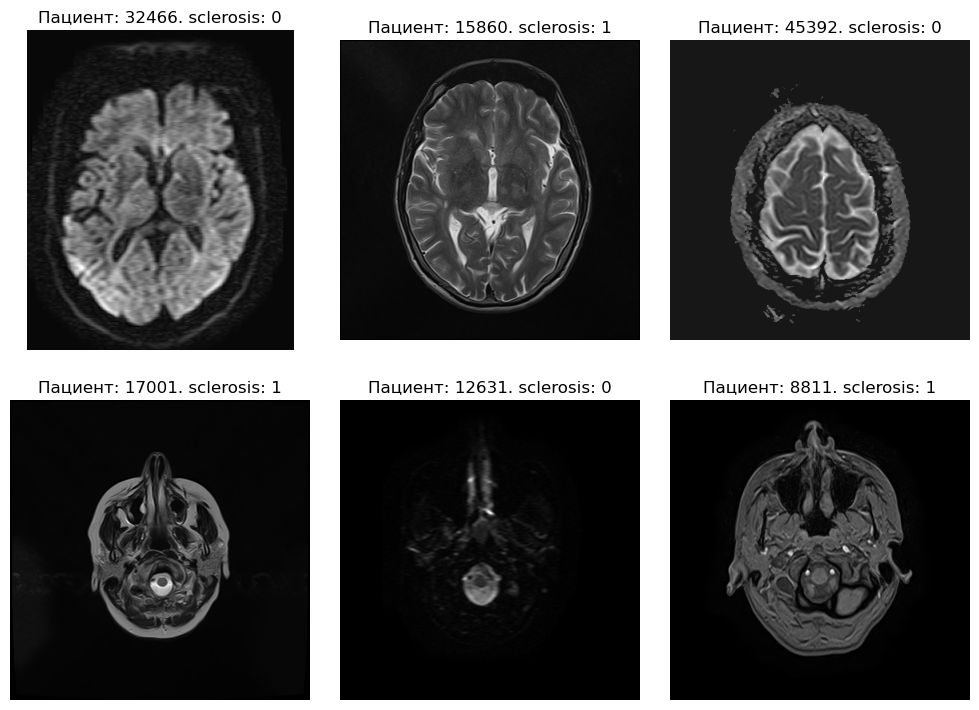

In [8]:
#функция загрузки данных из файла DICOM
#загружает и обрабатывает DICOM-изображение из файла с указанным путем path и возвращает его в виде numpy-массива
def read_dicom_image(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32) #преобразование изображения в numpy-массив
    intercept = dcm.RescaleIntercept if 'RescaleIntercept' in dcm else 0.0
    slope = dcm.RescaleSlope if 'RescaleSlope' in dcm else 1.0
    img = slope * img + intercept #масштабирование
    return img

# создаем фигуру с 2 рядами и 3 колонками
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

try:
    # проходим по всем осям и устанавливаем в них позицию и отображение изображения
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.set_position([0.05+(i%3)*0.33, 0.95-(i//3)*0.45, 0.3, 0.4])
            indx = np.random.randint(len(data))
            ax.imshow(read_dicom_image(data.loc[indx,'path']), cmap='gray')
            ax.set_title('Пациент: {0}. sclerosis: {1}'.format(indx, data.loc[indx,'sclerosis'])) 
        ax.axis('off')
except:
    # проходим по всем осям и устанавливаем в них позицию и отображение изображения
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.set_position([0.05+(i%3)*0.33, 0.95-(i//3)*0.45, 0.3, 0.4])
            indx = np.random.randint(len(data))
            ax.imshow(read_dicom_image(data.loc[indx,'path']), cmap='gray')
            ax.set_title('Пациент: {0}. sclerosis: {1}'.format(indx, data.loc[indx,'sclerosis'])) 
        ax.axis('off')


# Деление на выборки

В наборе данных есть фотографии разных размеров. Вот список их размеров shape в списке [(384, 416), (748, 640), (384, 384), (512, 512), (384, 384), (768, 768), (288, 288), (640, 640), (384, 384), (384, 384), (768, 768), (22, 192, 192), (384, 384), (768, 768), (640, 640), (512, 512), (768, 768), (384, 384), (576, 576), (384, 384), (384, 384), (768, 768), (768, 768), (384, 384), (768, 768), (576, 576), (23, 192, 192), (48, 128, 128), (512, 512), (25, 192, 192), (768, 768), (192, 192), (384, 384), (384, 384), (384, 384), (512, 512), (640, 640), (768, 768), (512, 512), (640, 640), (384, 384), (768, 768)]. Нужно прировнять их общему размеру. Какой размер высоты и ширины лучше выбрать?

При выборе размера необходимо учитывать следующие факторы:
- Размер объектов, которые вы хотите распознавать на изображениях
- Количество памяти, доступной вашему компьютеру или серверу
- Скорость обучения и выполнения модели
- Необходимость сохранения качества изображений

Обычно используют размеры, кратные степеням двойки, так как они являются оптимальными для обработки графических данных на компьютере.

Исходя из представленных данных, можно попробовать выбрать размер 512x512, так как он встречается в наборе данных наибольшее количество раз.

In [9]:
%%time
# Путь к каталогу с изображениями
train_dir = 'for_image/train'

# Создание набора данных из изображений в каталоге
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Создание набора данных для валидации
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# Путь к каталогу с изображениями
test_dir = 'for_image/test'
# Создание набора данных для валидации
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=16,
    image_size=(512, 512),
    shuffle=True,
    seed=42,
)


Found 41493 files belonging to 2 classes.
Using 33195 files for training.
Found 41493 files belonging to 2 classes.
Using 8298 files for validation.
Found 10374 files belonging to 2 classes.
CPU times: total: 7.67 s
Wall time: 7.85 s


In [10]:
%%time
tofolder = 'datasets_16'
# Создаем папку для сохранения
if not os.path.exists(tofolder):
    os.mkdir(tofolder)

tofolder = 'datasets_16/train_dataset'
# Создаем папку для сохранения
if not os.path.exists(tofolder):
    os.mkdir(tofolder)
# Сохраняем датасет
tf.data.Dataset.save(train_dataset, tofolder)

tofolder = 'datasets_16/val_dataset'
# Создаем папку для сохранения
if not os.path.exists(tofolder):
    os.mkdir(tofolder)
tf.data.Dataset.save(val_dataset, tofolder)

tofolder = 'datasets_16/test_dataset'
# Создаем папку для сохранения
if not os.path.exists(tofolder):
    os.mkdir(tofolder)
tf.data.Dataset.save(test_dataset, tofolder)


CPU times: total: 3min 15s
Wall time: 28min 8s


Готово! Теперь можно переходить к машинному обучению.